# Analysis of Fredrika

### Preamble
Imports and constants

In [1]:
from py_fish.operation import (
    speed_profile_from_data,
    total_consumption_from_profile,
    consumption_profile_from_data,
    extract_transit_speed,
    distance_from_profile,
    custom_speed_profile,
)
from py_fish.plotting import (
    plot_speed_profile,
    plot_consumption_data,
    plot_profiles,
    plot_power_data,
)
from py_fish.engine import (
    calculate_consumption,
    EngineApplication,
    calculate_power_from_consumption,
)
from py_fish.loads import (
    calculate_propulsion_power,
    calculate_dc_energy,
    calculate_hydraulics_energy,
)
from py_fish.data import load_all_days, extract_low_acceleration, load_one_day


from py_fish.utils import components_to_profile
import matplotlib

plt = matplotlib.pyplot
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d
from scipy import stats
from pathlib import Path
import os
import folium

In [2]:
ENGINE_RATING = 242.0
LENGTH = 11.91
BEAM = 4.0
DATE = "2023-11-07"
MOTOR_EFFICIENCY = 0.96
BATTERY_EFFICIENCY = 0.96
VESSEL = "fredrika"

Dates 2023-10-24 and 2023-10-30 gives significantly less predicted consumption.
Both have significant acceleration time.

### Speed profile
Plot of speed profile for specified date

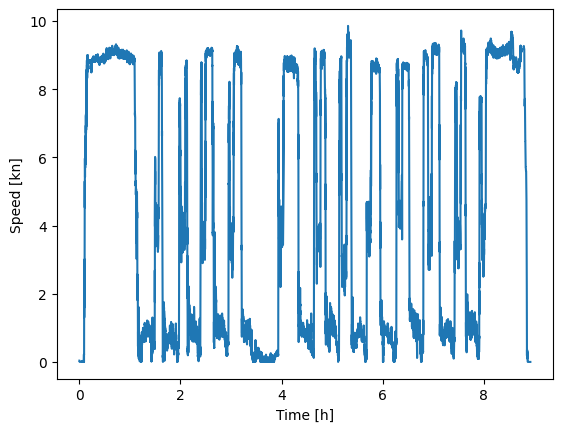

In [3]:
fig, ax = plt.subplots()
plot_speed_profile(speed_profile_from_data(vessel=VESSEL, date=DATE), ax=ax)

### All consumption data compared with Kemp model

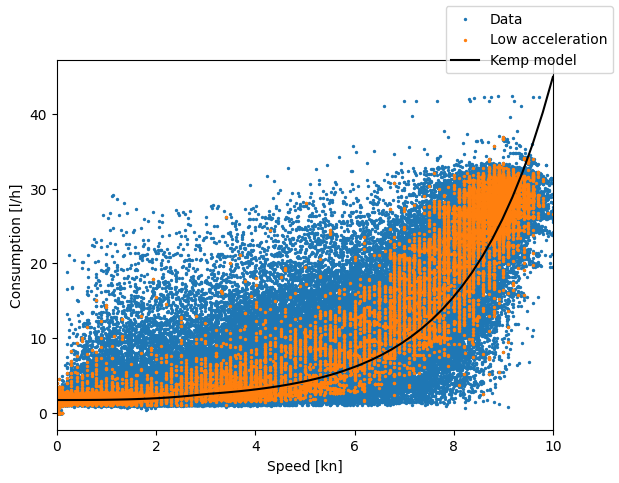

In [4]:
fig, ax = plt.subplots()
df = load_all_days(vessel=VESSEL)
speeds = np.linspace(0, 10)

speed_and_consumption = df.select(["speed", "consumption"]).to_numpy()
low_acceleration_speed_and_consumption = extract_low_acceleration(speed_and_consumption)

propulsion_powers_kemp = calculate_propulsion_power(
    speeds=speeds, length=LENGTH, beam=BEAM
)
propulsion_consumptions_kemp = calculate_consumption(
    powers=propulsion_powers_kemp,
    engine_rating=ENGINE_RATING,
    engine_application=EngineApplication.PROPULSION,
)

plot_consumption_data(speed_and_consumption, ax, label="Data")
plot_consumption_data(
    low_acceleration_speed_and_consumption, ax, label="Low acceleration"
)
ax.plot(
    speeds,
    propulsion_consumptions_kemp,
    label="Kemp model",
    color="black",
    linestyle="-",
)
fig.legend()

### Fit power models
Assumes engine consumption model by Kemp to be accurate, fits load model to the data

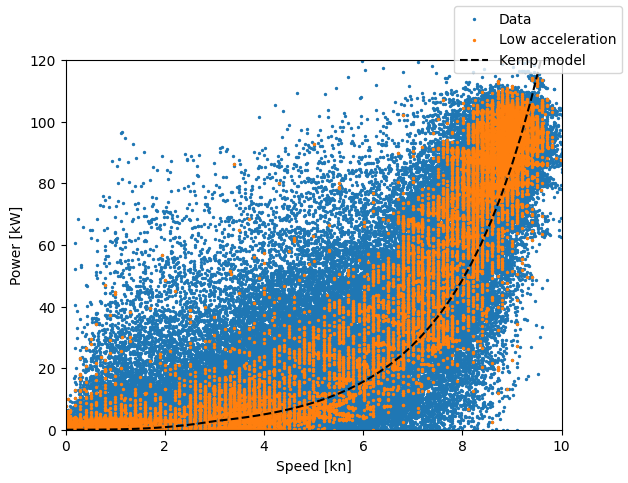

In [5]:
fig, ax = plt.subplots()
speed_and_power = components_to_profile(
    speed_and_consumption[:, 0],
    calculate_power_from_consumption(
        consumptions=speed_and_consumption[:, 1],
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)
low_acceleration_speed_and_power = components_to_profile(
    low_acceleration_speed_and_consumption[:, 0],
    calculate_power_from_consumption(
        consumptions=low_acceleration_speed_and_consumption[:, 1],
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)

plot_power_data(speed_and_power, ax, label="Data")
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(
    speeds, propulsion_powers_kemp, label="Kemp model", color="black", linestyle="--"
)
fig.legend()

Fits the constant parameter of the kemp model, i.e. not changeing the exponent

Power increawse with fit: 11.56%


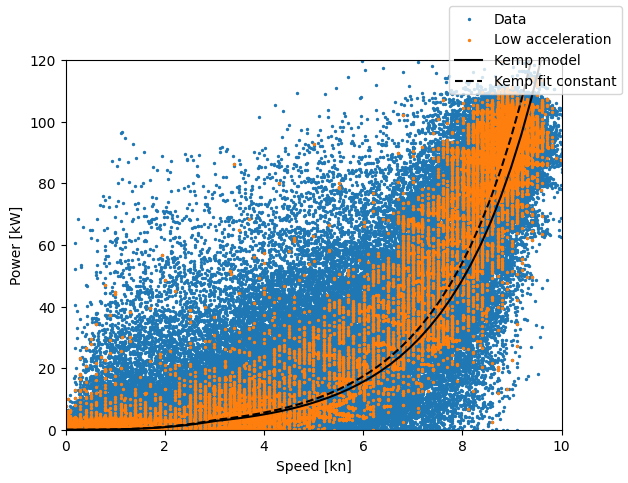

In [6]:
def power_function(speed: float, c4: float) -> float:
    return calculate_propulsion_power(
        speeds=np.ones((1, 1), dtype=float) * speed, length=LENGTH, beam=BEAM, c4=c4
    )[0]


popt, pcov = curve_fit(
    power_function,
    low_acceleration_speed_and_power[:, 0],
    low_acceleration_speed_and_power[:, 1],
)
propulsion_powers_kemp_fit = calculate_propulsion_power(
    speeds=speeds, length=LENGTH, beam=BEAM, c4=popt[0]
)

fig, ax = plt.subplots()
plot_power_data(speed_and_power, ax, label="Data")
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(speeds, propulsion_powers_kemp, label="Kemp model", color="black")
ax.plot(
    speeds,
    propulsion_powers_kemp_fit,
    label="Kemp fit constant",
    color="black",
    linestyle="--",
)
fig.legend()
power_increase = popt[0] / 3.6e-3
print(f"Power increawse with fit: {(power_increase-1)*100.0:.2f}%")

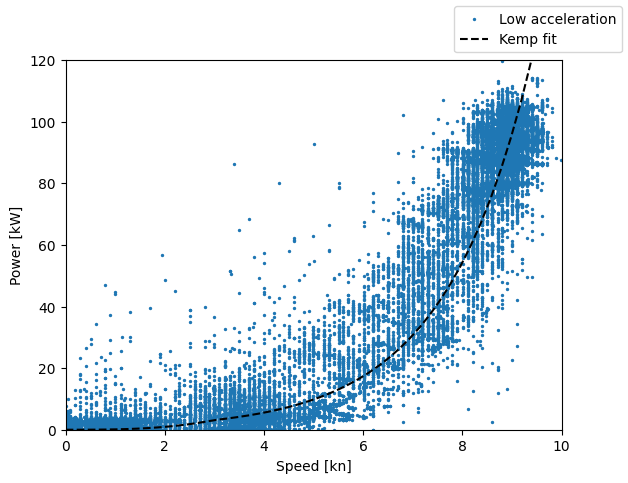

In [7]:
fig, ax = plt.subplots()
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(
    speeds,
    propulsion_powers_kemp_fit,
    label="Kemp fit",
    color="black",
    linestyle="--",
)
fig.legend()

1.1149016361697472 1.1155810074699406 1.116260378770134


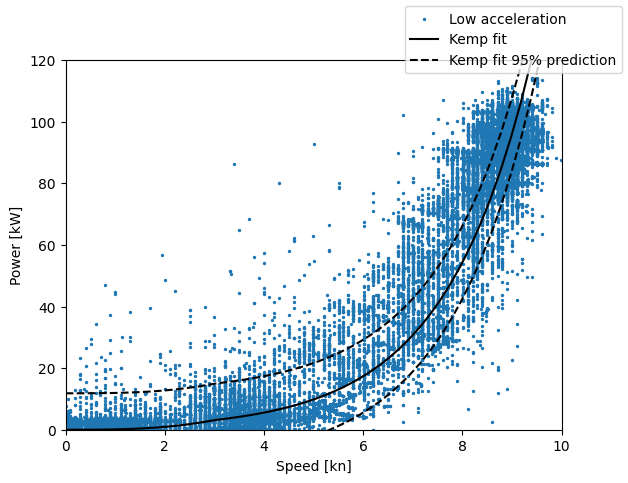

In [8]:
beta = popt[0]
level = 0.95
alpha = 1 - level
se = np.sqrt(pcov[0, 0])
n = len(low_acceleration_speed_and_power[:, 0])
beta_u = beta + stats.t.ppf(alpha / 2.0, n - 1) * se
beta_l = beta + stats.t.ppf(1 - alpha / 2.0, n - 1) * se
print(beta_u / 3.6e-3, beta / 3.6e-3, beta_l / 3.6e-3)

GS = (
    np.power(
        calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=beta), 2
    )
    * 0.57
    * 0.57
    * pcov[0, 0]
)

beta_u_delta = beta + stats.t.ppf(alpha / 2.0, n - 1) * np.sqrt(GS)
beta_l_delta = beta + stats.t.ppf(1 - alpha / 2.0, n - 1) * np.sqrt(GS)
residual_variance = np.sum(
    np.power(
        low_acceleration_speed_and_power[:, 1]
        - calculate_propulsion_power(
            speeds=low_acceleration_speed_and_power[:, 0],
            length=LENGTH,
            beam=BEAM,
            c4=beta,
        ),
        2,
    )
) / (n - 2)
delta_y = np.sqrt(GS + residual_variance) * stats.t.ppf(1 - alpha / 2.0, n - 1)

fig, ax = plt.subplots()
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(
    speeds,
    propulsion_powers_kemp_fit,
    label="Kemp fit",
    color="black",
    linestyle="-",
)
ax.plot(
    speeds,
    calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=beta)
    + delta_y,
    label="Kemp fit 95% prediction",
    color="black",
    linestyle="--",
)
ax.plot(
    speeds,
    calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=beta)
    - delta_y,
    color="black",
    linestyle="--",
)
fig.legend()

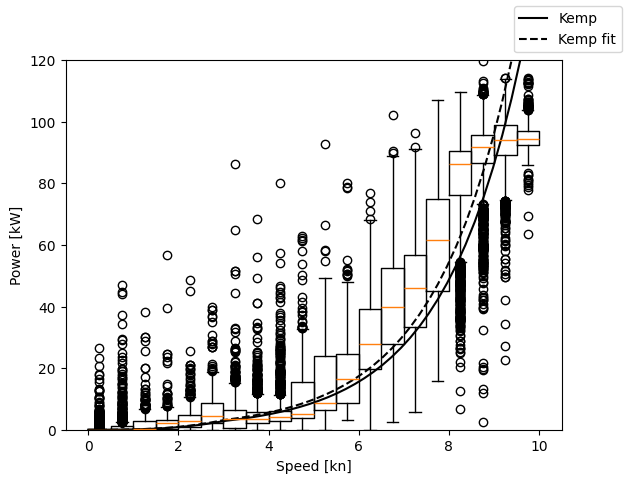

In [9]:
bin_size = 0.5
bins = np.arange(0, 10.1, bin_size)
bins_data = list()
for i in range(0, len(bins) - 1):
    bins_data.append(
        low_acceleration_speed_and_power[
            np.logical_and(
                low_acceleration_speed_and_power[:, 0] >= bins[i],
                low_acceleration_speed_and_power[:, 0] < bins[i + 1],
            ),
            1,
        ]
    )
fig, ax = plt.subplots()
# plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.boxplot(
    bins_data, positions=bins[0:-1] + bin_size / 2, widths=0.5, manage_ticks=False
)
ax.plot(
    speeds,
    propulsion_powers_kemp,
    label="Kemp",
    color="black",
    linestyle="-",
)
ax.plot(
    speeds,
    propulsion_powers_kemp_fit,
    label="Kemp fit",
    color="black",
    linestyle="--",
)
ax.set_ylim([0, 120])
ax.set_ylabel("Power [kW]")
ax.set_xlabel("Speed [kn]")
fig.legend()

### Extract transit
Extract operational modes for the selected date and calculate time fishing

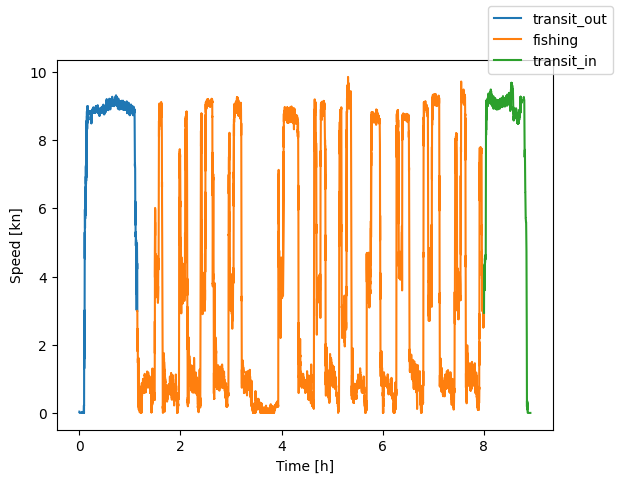

In [10]:
fig, ax = plt.subplots()
measured_speed_profile = speed_profile_from_data(vessel=VESSEL, date=DATE)
(transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
time_fishing = fishing[-1, 0] - fishing[0, 0]
plot_profiles(ax, transit_out=transit_out, fishing=fishing, transit_in=transit_in)
ax.set_xlabel("Time [h]")
ax.set_ylabel("Speed [kn]")
fig.legend()

### Compare measured and approximated fuel usage for one day

Measured consumption: 107.41
Consumption from standard Kemp: 100.31
Consumption from fitted Kemp: 109.71


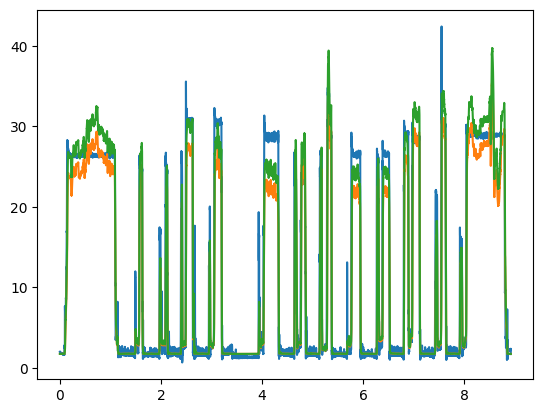

In [11]:
measured_consumption_profile = consumption_profile_from_data(vessel=VESSEL, date=DATE)
measured_consumption = total_consumption_from_profile(measured_consumption_profile)

model_power = calculate_propulsion_power(
    speeds=uniform_filter1d(measured_speed_profile[:, 1], size=30),
    length=LENGTH,
    beam=BEAM,
)
model_power_fit = model_power * power_increase

model_consumption_profile = components_to_profile(
    measured_speed_profile[:, 0],
    calculate_consumption(
        powers=model_power,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)

model_consumption_profile_fit = components_to_profile(
    measured_speed_profile[:, 0],
    calculate_consumption(
        powers=model_power_fit,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)

model_consumption_propulsion = total_consumption_from_profile(model_consumption_profile)
model_consumption_propulsion_fit = total_consumption_from_profile(
    model_consumption_profile_fit
)
power_hydraulics = calculate_hydraulics_energy(
    hours_fishing=time_fishing, hydraulic_deck_load_power=2.0
)
power_dc = calculate_dc_energy(
    hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]
)
hydraulics_consumption = calculate_consumption(
    powers=power_hydraulics,
    engine_rating=ENGINE_RATING,
    engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
)
dc_consumption = calculate_consumption(
    powers=power_dc,
    engine_rating=ENGINE_RATING,
    engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
)

fig, ax = plt.subplots()
plot_profiles(
    ax,
    measured_consumption=measured_consumption_profile,
    model_consumption=model_consumption_profile,
    model_consumption_fit=model_consumption_profile_fit,
)
print(
    f"Measured consumption: {measured_consumption:.2f}\nConsumption from standard Kemp: {model_consumption_propulsion + hydraulics_consumption + dc_consumption:.2f}\nConsumption from fitted Kemp: {model_consumption_propulsion_fit + hydraulics_consumption + dc_consumption:.2f}"
)

### Compare measured and approximated fuel usage for all days

In [12]:
data_dir = Path(os.path.abspath("")).resolve() / "py_fish" / "fredrika"
files = [f for f in data_dir.iterdir() if f.is_file()]
output = open("fredrika_consumptions.csv", "w")
output.write(
    "date,measured,propulsion,propulsion_fit,hydraulics,dc,total,total_fit,kwh,kwh_fit\n"
)
output.close()
output = open("fredrika_consumptions.csv", "a")
for file in files:
    DATE = file.name[3:13]
    measured_speed_profile = speed_profile_from_data(vessel=VESSEL, date=DATE)
    (transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
    time_fishing = fishing[-1, 0] - fishing[0, 0]
    measured_consumption_profile = consumption_profile_from_data(
        vessel=VESSEL, date=DATE
    )
    measured_consumption = total_consumption_from_profile(measured_consumption_profile)
    model_power = calculate_propulsion_power(
        speeds=uniform_filter1d(measured_speed_profile[:, 1], size=30),
        length=LENGTH,
        beam=BEAM,
    )

    model_power_fit = model_power * power_increase

    model_power_total = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power)
    )
    model_power_total_fit = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power_fit)
    )
    model_consumption_profile = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_profile_fit = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power_fit,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_propulsion = total_consumption_from_profile(
        model_consumption_profile
    )
    model_consumption_propulsion_fit = total_consumption_from_profile(
        model_consumption_profile_fit
    )
    power_hydraulics = calculate_hydraulics_energy(
        hours_fishing=time_fishing, hydraulic_deck_load_power=2.0
    )
    power_dc = calculate_dc_energy(
        hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]
    )
    hydraulics_consumption = calculate_consumption(
        powers=power_hydraulics,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    dc_consumption = calculate_consumption(
        powers=power_dc,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    output.write(
        f"{DATE},{measured_consumption},{model_consumption_propulsion},{model_consumption_propulsion_fit},{hydraulics_consumption},{dc_consumption},{model_consumption_propulsion + hydraulics_consumption + dc_consumption},{model_consumption_propulsion_fit + hydraulics_consumption + dc_consumption},{(model_power_total + power_dc + power_hydraulics)/(MOTOR_EFFICIENCY * BATTERY_EFFICIENCY)},{(model_power_total_fit + power_dc + power_hydraulics)/(MOTOR_EFFICIENCY * BATTERY_EFFICIENCY)}\n"
    )

output.close()

### Other speed profiles
Use of theoretical speed profiles to evaluate when speed reduction is benificial

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


Time going out: 1.15 h
Time fishing: 6.86 h
Time going in: 0.92 h
Time total: 8.93 h


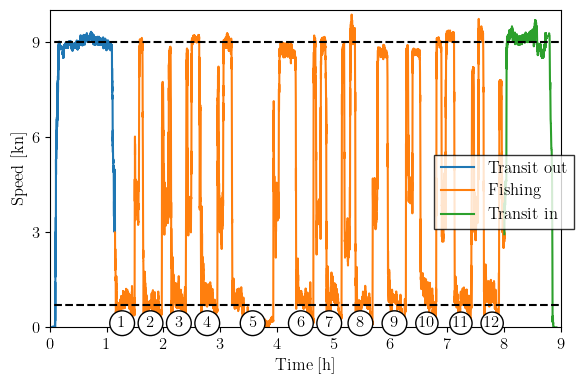

In [13]:
REPRESENTATIVE_DATE = "2023-11-07"
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 12})


fig, ax = plt.subplots(figsize=(5.90666, 4))

representative_profile = speed_profile_from_data(
    vessel=VESSEL, date=REPRESENTATIVE_DATE
)

(transit_out, fishing, transit_in) = extract_transit_speed(representative_profile)
plot_profiles(ax=ax, transit_out=transit_out, fishing=fishing, transit_in=transit_in)
xpos = [1.2, 1.7, 2.2, 2.7, 3.5, 4.35, 4.85, 5.4, 6.0, 6.5, 7.1, 7.65]
annotations = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
pad = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.18, 0.18, 0.18]


for xi, text, padi in zip(xpos, annotations, pad):

    ax.text(xi, 0, text, bbox=dict(boxstyle="circle", fc="white", pad=padi))


ax.plot([-1, 10], [9, 9], linestyle="--", color="black")
ax.plot([-1, 10], [0.7, 0.7], linestyle="--", color="black")
ax.set_xlim([0, 9])
ax.set_ylim([0, 10])
ax.set_yticks([0, 3, 6, 9])
ax.set_xlabel("Time [h]")
ax.set_ylabel("Speed [kn]")

fig.tight_layout()
lgd = fig.legend(
    ["Transit out", "Fishing", "Transit in"],
    loc=7,
    bbox_to_anchor=(1.0, 0.5),
    frameon=True,
    facecolor="white",
)
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.savefig(
    "figures/example_day.eps",
    format="eps",
)

time_transit_out = transit_out[-1, 0] - transit_out[0, 0]
time_fishing = fishing[-1, 0] - fishing[0, 0]
time_transit_in = transit_in[-1, 0] - transit_in[0, 0]
time_total = representative_profile[-1, 0] - representative_profile[0, 0]
print(
    f"Time going out: {time_transit_out:0.2f} h\nTime fishing: {time_fishing:0.2f} h\nTime going in: {time_transit_in:0.2f} h\nTime total: {time_total:0.2f} h"
)

Note that we have 12 strings of pots and a transit speed of 9 kn both going in/out and between pots. The speed when picking pots is 0.7 kn.

In [14]:
low_speed_fishing = fishing[fishing[:, 1] < 2.5, :]
intervals = np.diff(low_speed_fishing[:, 0])
time_picking_pots = sum(intervals[intervals < 0.1])
print(
    f"Average time per string of pots: {time_picking_pots / 12:.2f} h or {time_picking_pots / 12 * 60:.0f} min."
)
time_fishing_transit = time_fishing - time_picking_pots
print(f"Average time between strings: {time_fishing_transit/11:.2f} h")
len(intervals) - len(intervals[intervals < 0.1])

Average time per string of pots: 0.36 h or 22 min.
Average time between strings: 0.23 h


11

In [15]:
distance_out = distance_from_profile(transit_out)
distance_fishing = distance_from_profile(fishing)
distance_in = distance_from_profile(transit_in)
distance_total = distance_from_profile(representative_profile)
print(
    f"Distance out: {distance_out:0.2f} nm\nDistance fishing: {distance_fishing:0.2f} nm\nDistance in: {distance_in:0.2f} nm\nDistance total: {distance_total:0.2f} nm"
)

Distance out: 9.05 nm
Distance fishing: 22.63 nm
Distance in: 7.35 nm
Distance total: 39.03 nm


Standard Kemp: 370.55 kWh, 152.48 kWh
Fitted Kemp: 413.38 kWh, 170.10 kWh
8.76 h, 9.90 h
Standard Kemp: 111.98 l, 56.93 l
Fitted Kemp: 123.17 l, 61.54 l


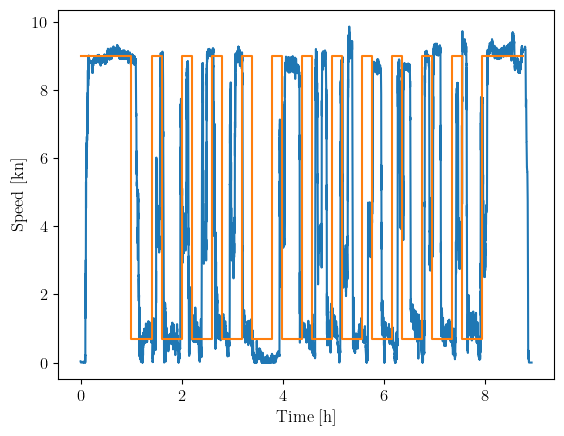

In [16]:
replica = custom_speed_profile(
    distance_out=distance_out,
    speed_out=9.0,
    distance_fishing=distance_fishing,
    speed_fishing=9.0,
    distance_in=distance_in,
    speed_in=9.0,
    time_per_pot=0.4,
)
lower_speed = custom_speed_profile(
    distance_out=distance_out,
    speed_out=7.0,
    distance_fishing=distance_fishing,
    speed_fishing=7.0,
    distance_in=distance_in,
    speed_in=7.0,
    time_per_pot=0.4,
)

fig, ax = plt.subplots()
plot_speed_profile(representative_profile, ax)
plot_speed_profile(replica, ax)
# plot_speed_profile(lower_speed, ax)
repilica_power = components_to_profile(
    replica[:, 0],
    calculate_propulsion_power(speeds=replica[:, 1], length=LENGTH, beam=BEAM),
)
lower_speed_power = components_to_profile(
    lower_speed[:, 0],
    calculate_propulsion_power(speeds=lower_speed[:, 1], length=LENGTH, beam=BEAM),
)

repilica_power_fit = components_to_profile(
    replica[:, 0],
    calculate_propulsion_power(speeds=replica[:, 1], length=LENGTH, beam=BEAM)
    * power_increase,
)
lower_speed_power_fit = components_to_profile(
    lower_speed[:, 0],
    calculate_propulsion_power(speeds=lower_speed[:, 1], length=LENGTH, beam=BEAM)
    * power_increase,
)

print(
    f"Standard Kemp: {total_consumption_from_profile(repilica_power)/(MOTOR_EFFICIENCY * BATTERY_EFFICIENCY):.2f} kWh, {total_consumption_from_profile(lower_speed_power)/(MOTOR_EFFICIENCY * BATTERY_EFFICIENCY):.2f} kWh"
)
print(
    f"Fitted Kemp: {total_consumption_from_profile(repilica_power_fit)/(MOTOR_EFFICIENCY * BATTERY_EFFICIENCY):.2f} kWh, {total_consumption_from_profile(lower_speed_power_fit)/(MOTOR_EFFICIENCY * BATTERY_EFFICIENCY):.2f} kWh"
)
print(
    f"{repilica_power[-1, 0] - repilica_power[0,0]:.2f} h, {lower_speed_power[-1, 0] - lower_speed_power[0,0]:.2f} h"
)
print(
    f"Standard Kemp: {total_consumption_from_profile(components_to_profile(repilica_power[:, 0], calculate_consumption(powers=repilica_power[:, 1], engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION))):.2f} l, {total_consumption_from_profile(components_to_profile(lower_speed_power[:, 0], calculate_consumption(powers=lower_speed_power[:, 1], engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION))):.2f} l"
)
print(
    f"Fitted Kemp: {total_consumption_from_profile(components_to_profile(repilica_power_fit[:, 0], calculate_consumption(powers=repilica_power_fit[:, 1], engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION))):.2f} l, {total_consumption_from_profile(components_to_profile(lower_speed_power_fit[:, 0], calculate_consumption(powers=lower_speed_power_fit[:, 1], engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION))):.2f} l"
)

Battery properties

In [17]:
kw_kg = 0.19
print(170.0 / 0.8)

print(170.0 / 0.8 / kw_kg)

212.5
1118.421052631579


### Map of the representative date with operational modes

In [18]:
df = load_one_day(vessel=VESSEL, date=REPRESENTATIVE_DATE)
coordinates = df.select(["time", "latitude", "longitude"]).to_numpy()
coordinates[:, 0] = (coordinates[:, 0] - coordinates[0, 0]) / (3600 * 1e6)

transit_out_coordinates = coordinates[
    np.logical_and(
        coordinates[:, 0] >= transit_out[0, 0], coordinates[:, 0] <= transit_out[-1, 0]
    ),
    :,
]
transit_in_coordinates = coordinates[
    np.logical_and(
        coordinates[:, 0] >= transit_in[0, 0], coordinates[:, 0] <= transit_in[-1, 0]
    ),
    :,
]
fishing_coordinates = coordinates[
    np.logical_and(
        coordinates[:, 0] >= fishing[0, 0], coordinates[:, 0] <= fishing[-1, 0]
    ),
    :,
]
m = folium.Map(
    location=[58.72, 11.05],
    control_scale=True,
    zoom_start=12,
    min_zoom=12,
    tiles="cartodb positron",
)
folium.PolyLine(
    transit_in_coordinates[:, 1:], tooltip="Transit in", color="#2ca02c"
).add_to(m)
folium.PolyLine(
    transit_out_coordinates[:, 1:], tooltip="Transit out", color="#1f77b4"
).add_to(m)
folium.PolyLine(fishing_coordinates[:, 1:], tooltip="Fishing", color="#ff7f0e").add_to(
    m
)


for i in xpos:
    pot = fishing_coordinates[fishing_coordinates[:, 0] > i, :][0][1:]

    folium.CircleMarker(location=pot, radius=6.0, color="black").add_to(m)
print(coordinates[0, 1:])
m

[58.75572    11.17778171]
